In [79]:
import duckdb as ddb
import matplotlib.pyplot as plt
import pandas as pd

data = ddb.read_parquet("../week3/rplace.parquet")

In [80]:
# find the user with the highest avg distance between pixel placements (min 100 placements)
avg_distances = ddb.sql(f"""
    WITH min_100 AS (
        SELECT
            user_id_numeric,
        FROM data
        GROUP BY user_id_numeric
        HAVING COUNT(*) >= 100  
    ), user_coords AS (
        SELECT
            d.user_id_numeric as user_id,
            x,
            y,
            LAG(x) OVER (PARTITION BY user_id ORDER BY timestamp) AS prev_x,
            LAG(y) OVER (PARTITION BY user_id ORDER BY timestamp) AS prev_y,
            timestamp
        FROM data AS d
        JOIN min_100 AS m ON m.user_id_numeric = d.user_id_numeric
        ORDER BY user_id, timestamp
    ), distances AS (
        SELECT
            user_id,
            ROUND(SQRT(POWER(x - prev_x, 2) + POWER(y - prev_y, 2)), 2) as eucl_dist
        FROM user_coords
        WHERE prev_x IS NOT NULL AND prev_y IS NOT NULL
    )
    SELECT
        user_id,
        AVG(eucl_dist) as avg_dist
    FROM distances
    GROUP BY user_id
    ORDER BY avg_dist DESC
""").fetchdf()

print(avg_distances.head(10))

   user_id     avg_dist
0  5160944  1379.085118
1  6031349  1341.881405
2   102799  1334.697030
3  7285664  1327.378560
4  6059850  1320.024138
5  3478514  1310.574134
6  6414017  1301.147320
7  3342586  1296.243675
8  8520573  1295.947087
9  6493276  1289.837205


In [90]:
# find the user with the highest avg distance between pixel placements (min 100 placements)
percentiles = ddb.sql(f"""
    SELECT
        ROUND(PERCENTILE_DISC(0.5) WITHIN GROUP (ORDER BY avg_dist), 2) AS percentile_50,
        ROUND(PERCENTILE_DISC(0.75) WITHIN GROUP (ORDER BY avg_dist), 2) AS percentile_75,
        ROUND(PERCENTILE_DISC(0.90) WITHIN GROUP (ORDER BY avg_dist), 2) AS percentile_90,
        ROUND(PERCENTILE_DISC(0.99) WITHIN GROUP (ORDER BY avg_dist), 2) AS percentile_99
    FROM avg_distances;
""").fetchdf()

# grab top 3 users placement coords, colors, timestamps
user_data = ddb.sql(f"""
    SELECT *
    FROM data
    WHERE user_id_numeric IN (5160944, 6031349, 102799)
    ORDER BY user_id_numeric, timestamp
""").fetchdf()
user_data_2 = user_data

# for each unique user in 'user_data', grab the amount of rows they placed and their most placed color
user_stats = ddb.sql(f"""
    WITH color_counts AS (
        SELECT
            user_id_numeric,
            pixel_color,
            COUNT(*) AS color_count,
            ROW_NUMBER() OVER (PARTITION BY user_id_numeric ORDER BY COUNT(*) DESC) AS rank
        FROM user_data
        GROUP BY user_id_numeric, pixel_color
    )
    SELECT
        user_id_numeric,
        pixel_color,
        color_count
    FROM color_counts
    WHERE rank <= 3
    ORDER BY user_id_numeric, rank
""").fetchdf()


print(percentiles)
print()
print(user_data)
print()
print(user_stats)


   percentile_50  percentile_75  percentile_90  percentile_99
0         242.93         361.02         468.35         716.65

                  timestamp pixel_color     x     y  user_id_numeric
0   2022-04-03 15:43:14.975     #811E9F  1600     0           102799
1   2022-04-03 15:50:14.989     #FF4500   886    15           102799
2   2022-04-03 16:07:20.477     #FF4500   886    14           102799
3   2022-04-04 09:18:54.956     #FFA800   635     4           102799
4   2022-04-04 12:47:26.957     #E4ABFF   662  1880           102799
..                      ...         ...   ...   ...              ...
347 2022-04-04 22:25:53.376     #FFA800  1044  1958          6031349
348 2022-04-04 22:31:01.281     #FFFFFF   725  1880          6031349
349 2022-04-04 22:36:21.689     #6D001A   620  1823          6031349
350 2022-04-04 22:41:36.201     #FFFFFF   697    23          6031349
351 2022-04-04 22:46:46.725     #898D90   476    16          6031349

[352 rows x 5 columns]

   user_id_numeric pix

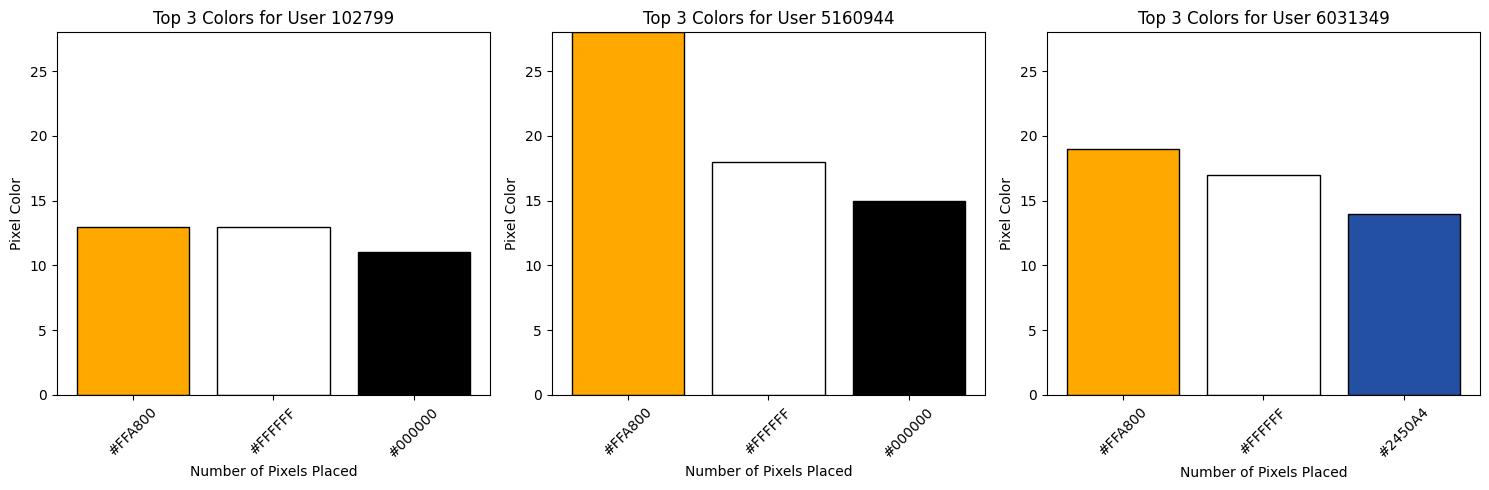

In [92]:
# Get unique users
unique_users = user_stats['user_id_numeric'].unique()

# Create a figure for the combined bar charts with horizontal layout
fig, axes = plt.subplots(nrows=1, ncols=len(unique_users), figsize=(5 * len(unique_users), 5))

# Determine the maximum count for normalization
max_count = user_stats['color_count'].max()

# Loop through each user and create a bar chart
for ax, user in zip(axes, unique_users):
    user_data = user_stats[user_stats['user_id_numeric'] == user]
    ax.bar(user_data['pixel_color'], user_data['color_count'], color=user_data['pixel_color'], edgecolor='black')
    ax.set_title(f'Top 3 Colors for User {user}')
    ax.set_xlabel('Number of Pixels Placed')
    ax.set_ylabel('Pixel Color')
    ax.set_xticks(user_data['pixel_color'])
    ax.set_xticklabels(user_data['pixel_color'], rotation=45)
    
    # Set the y-axis limit to the maximum count across all users
    ax.set_ylim(0, max_count)

# Adjust layout
plt.tight_layout()
plt.show()

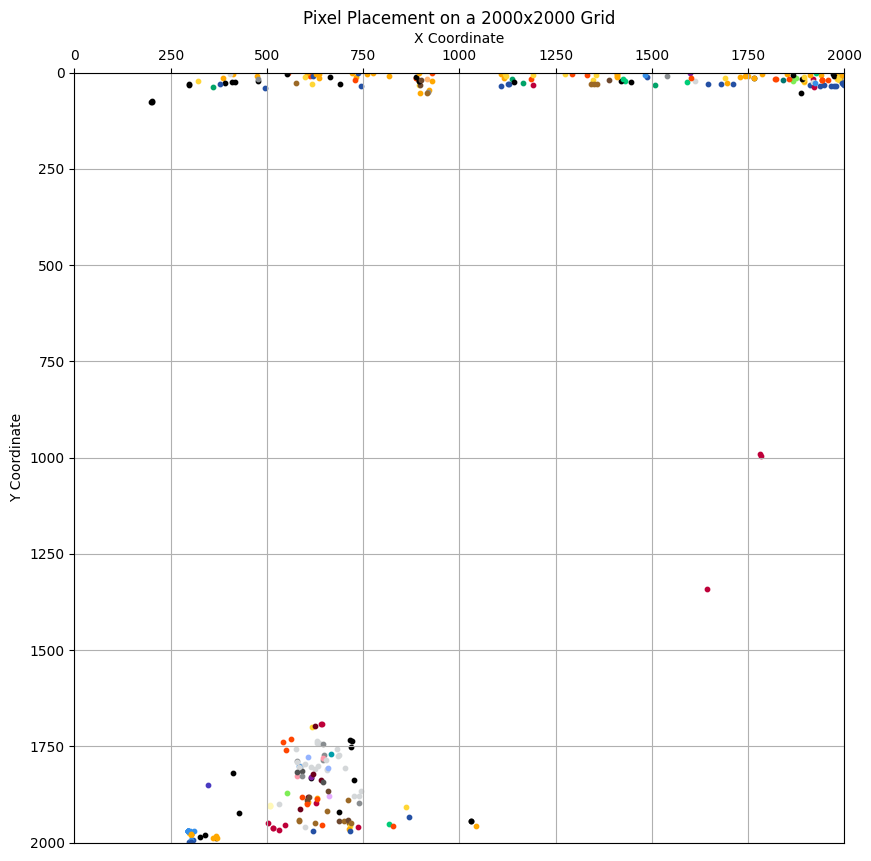

In [93]:
# Create a new figure with a 2000x2000 grid
plt.figure(figsize=(10, 10))

# Plot each pixel
for index, row in user_data_filtered.iterrows():
    # Extract coordinates and color
    x = row['x']  # Replace with the actual column name for x-coordinates
    y = row['y']  # Replace with the actual column name for y-coordinates
    color = row['pixel_color']
    
    # Plot the pixel as a square
    plt.scatter(x, y, color=color, s=10)  # Adjust 's' for size of the pixels

# Set limits to fit the 2000x2000 grid
plt.xlim(0, 2000)
plt.ylim(0, 2000)
plt.gca().set_aspect('equal', adjustable='box')  # Keep aspect ratio

# Invert the y-axis to have the origin at the top left
plt.gca().invert_yaxis()

# Add title and labels
plt.title('Pixel Placement on a 2000x2000 Grid')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')

# Move x-axis labels to the top
plt.gca().xaxis.set_ticks_position('top')  # Move x-axis ticks to the top
plt.gca().xaxis.set_label_position('top')

# Show grid lines for better visualization
plt.grid(True)

# Show the plot
plt.show()

## Ideas
1. Most colorful user
- In duckDB this query works: realized the color pallet was very small and the max amount of unique colors possible to color was very low, so this is not interesting.
2. User with the most distance placed between pixels on average
- This one turned out the be the most fun and informative (as far as relevant analysis that lead to a reasonable conclusion). Initially, I thought the data was suggesting that the top 3 user's for this category were a part of the German community given that some of their top colors were yellow and black, but upon plotting the coordinates in a grid, I came to realize that this was actually the Netherlands community. This explained the blue and white colors that were also a part of their top placements. There were primarily two locations that the Netherlands community helped to create, and those happened to be on opposite sides of the canvas from one another, which also contributed to the mean euclidean distance being so great for these users.
3. 1 time user statistics vs 2-25 vs 26-100 
- Did not get to this one.